In [29]:
!python -V

Python 3.9.19


In [30]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
import pickle

Read in taxi data using pandas.

In [31]:
df = pd.read_parquet('../data/green_tripdata_2023-01.parquet')


Note that the dropoff/pickup time data has already datatime format, so there's no need to convert it

In [32]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [33]:
col = df.columns
print('Number of columns: ', len(col))

Number of columns:  20


Now we calculate the duration of each trip

In [34]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

the duration is a full datetime bit with minutes and seconds:

In [35]:
df.duration

0       0 days 00:11:01
1       0 days 00:06:46
2       0 days 00:06:20
3       0 days 00:05:49
4       0 days 00:05:58
              ...      
68206   0 days 00:13:00
68207   0 days 00:08:00
68208   0 days 00:16:00
68209   0 days 00:18:00
68210   0 days 00:16:00
Name: duration, Length: 68211, dtype: timedelta64[us]

Since it is too granular, we just convert duration as a fraction of minutes

In [36]:
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration

0        11.016667
1         6.766667
2         6.333333
3         5.816667
4         5.966667
           ...    
68206    13.000000
68207     8.000000
68208    16.000000
68209    18.000000
68210    16.000000
Name: duration, Length: 68211, dtype: float64

~~Now we filter by just getting any trips that were only street-hail (trip type 2)~~

turns out that filtering by only using street hail means that we have a lot of trips that last less than 1 minute. So we will just comment it out and keep both the street hail and the pre booked ones.

In [37]:
# df = df[df.trip_type == 2]
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.90,...,0.5,4.03,0.0,None,1.0,24.18,1.0,1.0,2.75,11.016667
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.70,...,0.5,2.64,0.0,None,1.0,15.84,1.0,1.0,0.00,6.766667
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.20,...,0.5,1.94,0.0,None,1.0,11.64,1.0,1.0,0.00,6.333333
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.50,...,1.5,1.70,0.0,None,1.0,10.20,1.0,1.0,0.00,5.816667
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.00,...,1.5,0.00,0.0,None,1.0,8.00,1.0,1.0,0.00,5.966667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,None,NaN,49,62,NaN,4070.82,15.70,...,0.0,0.00,0.0,None,1.0,16.70,NaN,NaN,NaN,13.000000
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,None,NaN,10,205,NaN,2.14,4.41,...,0.0,0.00,0.0,None,1.0,5.41,NaN,NaN,NaN,8.000000
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,None,NaN,66,37,NaN,3.44,16.53,...,0.0,3.51,0.0,None,1.0,21.04,NaN,NaN,NaN,16.000000
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,None,NaN,225,189,NaN,3.03,14.98,...,0.0,3.20,0.0,None,1.0,19.18,NaN,NaN,NaN,18.000000


Now we plot the distribution of the duration using sns

/Users/andreanicolas/anaconda3/envs/mlops_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='duration', ylabel='Count'>

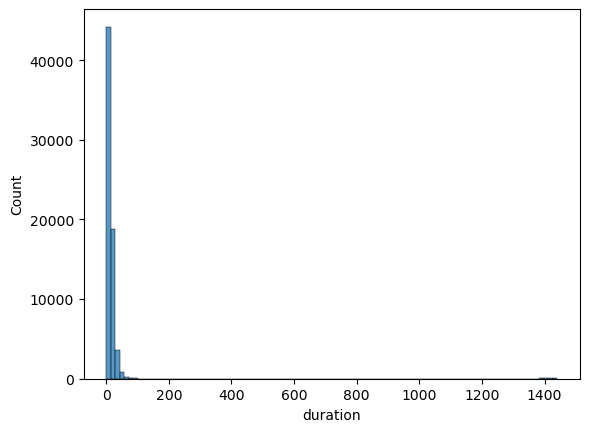

In [38]:
sns.histplot(df.duration,bins=100)

It has a bunch of outliers (max is days long, min is nonrunning trips), so the distribution can't be seen really well...

In [39]:
df.duration.describe()

count    68211.000000
mean        18.097271
std         74.925631
min          0.000000
25%          7.216667
50%         11.400000
75%         17.483333
max       1439.883333
Name: duration, dtype: float64

We will filter so that we only keep data betwen 1 and 60 mins (inclusive)

In [40]:
mask = ((df.duration >=1) & (df.duration<=60))
total_n = len(mask)
filtered_n = mask.sum()
print(f'percentage left after dropping outliers is {filtered_n/total_n*100:.2f}%')

percentage left after dropping outliers is 96.68%


In [41]:
df = df[mask]
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.90,...,0.5,4.03,0.0,None,1.0,24.18,1.0,1.0,2.75,11.016667
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.70,...,0.5,2.64,0.0,None,1.0,15.84,1.0,1.0,0.00,6.766667
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.20,...,0.5,1.94,0.0,None,1.0,11.64,1.0,1.0,0.00,6.333333
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.50,...,1.5,1.70,0.0,None,1.0,10.20,1.0,1.0,0.00,5.816667
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.00,...,1.5,0.00,0.0,None,1.0,8.00,1.0,1.0,0.00,5.966667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,None,NaN,49,62,NaN,4070.82,15.70,...,0.0,0.00,0.0,None,1.0,16.70,NaN,NaN,NaN,13.000000
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,None,NaN,10,205,NaN,2.14,4.41,...,0.0,0.00,0.0,None,1.0,5.41,NaN,NaN,NaN,8.000000
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,None,NaN,66,37,NaN,3.44,16.53,...,0.0,3.51,0.0,None,1.0,21.04,NaN,NaN,NaN,16.000000
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,None,NaN,225,189,NaN,3.03,14.98,...,0.0,3.20,0.0,None,1.0,19.18,NaN,NaN,NaN,18.000000


Now we set the categorical and numerical variables to use

In [42]:
categorical = ['PULocationID', 'DOLocationID'] # pickup and dropoff location
numerical = ['trip_distance'] # distance of trip
df[categorical].dtypes #int64

PULocationID    int64
DOLocationID    int64
dtype: object

Now we will do one hot encoding (converting things to 0s and 1s).
First we will convert the categoricals to just objects.
The reason to make the categoricals strings is because otherwise the dataframe will label encode them.

In [43]:
df[categorical] = df[categorical].astype(str)
df[categorical].dtypes #object

/var/folders/fm/8gkkcxbn0y3896pxrr1p0nqh0000gn/T/ipykernel_96436/707467286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


PULocationID    object
DOLocationID    object
dtype: object

We convert each row to a dictionary, and we will use the dictionary vectorizer to convert the dictionary to just vectors.

In [44]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [45]:
train_dicts[:10]

[{'PULocationID': '166', 'DOLocationID': '143', 'trip_distance': 2.58},
 {'PULocationID': '24', 'DOLocationID': '43', 'trip_distance': 1.81},
 {'PULocationID': '223', 'DOLocationID': '179', 'trip_distance': 0.0},
 {'PULocationID': '41', 'DOLocationID': '238', 'trip_distance': 1.3},
 {'PULocationID': '41', 'DOLocationID': '74', 'trip_distance': 1.1},
 {'PULocationID': '41', 'DOLocationID': '262', 'trip_distance': 2.78},
 {'PULocationID': '181', 'DOLocationID': '45', 'trip_distance': 3.8},
 {'PULocationID': '24', 'DOLocationID': '75', 'trip_distance': 1.88},
 {'PULocationID': '41', 'DOLocationID': '166', 'trip_distance': 1.11},
 {'PULocationID': '24', 'DOLocationID': '140', 'trip_distance': 4.22}]

In [46]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

we can check the no of columns and the feature names for each column

In [47]:
dv.feature_names_[:20]

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121']

In [48]:
print(f'no of columns on one hot: {X_train.shape[1]}')

no of columns on one hot: 468


Now that we have the X variables, we also need to set the target

In [49]:
target = 'duration'
y_train = df[target].values

In [50]:
y_train

array([11.01666667,  6.76666667,  6.33333333, ..., 16.        ,
       18.        , 16.        ])

Now that we have the x and y for training, we can fit a model to this.
Remember, this is basically:
duration = f(dropoff location, pickup location, trip distance)

We will fit a simple linear regression model:

In [51]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

Now we will predict the duration based on the training data

In [52]:
y_pred = lr.predict(X_train)


/var/folders/fm/8gkkcxbn0y3896pxrr1p0nqh0000gn/T/ipykernel_96436/951012812.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred,label='prediction')
/Users/andreanicolas/anaconda3/envs/mlops_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/fm/8gkkcxbn0y3896pxrr1p0nqh0000gn/T/ipykernel_96436/951012812.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

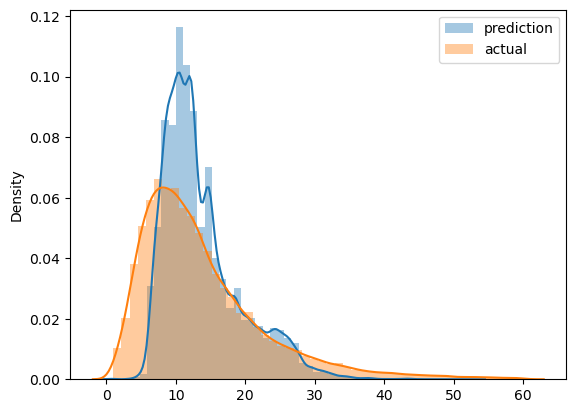

In [53]:
sns.distplot(y_pred,label='prediction')
sns.distplot(y_train,label='actual')
plt.legend()

The prediction and the actual values look pretty different. This means that the model is probably not particularly good. We can calcualte the performance of this model using the root mean square error RMSE.

In [54]:
train_rmse = root_mean_squared_error(y_train,y_pred)
print(f'RMSE from train data is : {train_rmse:.2f}')

RMSE from train data is : 7.06


We should check now how it performs with the validation dataset. We will create a function that we can use to preprocess the data

In [55]:
def read_dataframe(filename):
    df = pd.read_parquet(filename) #read data
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime # calculate duration
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60) # convert to mins
    mask = ((df.duration >=1) & (df.duration<=60)) # select only significant data
    df = df[mask]
    categorical = ['PULocationID', 'DOLocationID'] # pickup and dropoff location
    df[categorical] = df[categorical].astype(str) # convert to string/object to prevent labeling

    return df

Now we read in both the training and the validation data using this function:

In [56]:
df_train = read_dataframe('../data/green_tripdata_2023-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2023-02.parquet')

We check the length of each dataframe

In [57]:
len(df_train),len(df_val)

(65946, 62574)

We repeat the one-hotting and calculate RMSE. Note that it got worse, and if looking at the video, lasso and ridge models actually do not fare any better.

In [58]:
dv = DictVectorizer()
lr = LinearRegression()
categorical = ['PULocationID', 'DOLocationID'] # pickup and dropoff location
numerical = ['trip_distance'] # distance of trip

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts) # no need to fit sicne its done already for training data

y_train = df_train['duration'].values
y_val = df_val['duration'].values

lr.fit(X_train,y_train)

y_pred_train = lr.predict(X_train)
y_pred_val   = lr.predict(X_val)

train_rmse = root_mean_squared_error(y_train,y_pred_train)
val_rmse   = root_mean_squared_error(y_val,y_pred_val)

print(f'RMSE from train data is : {train_rmse:.2f}')
print(f'RMSE from validation data is : {val_rmse:.2f}')


RMSE from train data is : 7.06
RMSE from validation data is : 7.36


To improve things, we combine the dropoff/pickup locations into one variable and repeat the process

In [59]:
print('combining pickup location ID and dropoff location ID...')
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

dv = DictVectorizer()
lr = LinearRegression()
categorical = ['PU_DO'] # pickup and dropoff location
numerical = ['trip_distance'] # distance of trip

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts) # no need to fit sicne its done already for training data

y_train = df_train['duration'].values
y_val = df_val['duration'].values

lr.fit(X_train,y_train)

y_pred_train = lr.predict(X_train)
y_pred_val   = lr.predict(X_val)

train_rmse = root_mean_squared_error(y_train,y_pred_train)
val_rmse   = root_mean_squared_error(y_val,y_pred_val)

print(f'RMSE from train data is : {train_rmse:.2f}')
print(f'RMSE from validation data is : {val_rmse:.2f}')

combining pickup location ID and dropoff location ID...
RMSE from train data is : 4.79
RMSE from validation data is : 6.04


Linear regression works best for the data. Lasso and ridge tend to fare same or worse.

In [60]:
lr_lasso = Lasso(0.001)
lr_lasso.fit(X_train,y_train)

y_pred_train = lr_lasso.predict(X_train)
y_pred_val   = lr_lasso.predict(X_val)

train_rmse = root_mean_squared_error(y_train,y_pred_train)
val_rmse   = root_mean_squared_error(y_val,y_pred_val)

print(f'RMSE from train data using Lasso is : {train_rmse:.2f}')
print(f'RMSE from validation data using Lasso is : {val_rmse:.2f}')

RMSE from train data using Lasso is : 6.42
RMSE from validation data using Lasso is : 6.74


In [61]:
lr_ridge = Ridge(alpha=0.001)
lr_ridge.fit(X_train,y_train)

y_pred_train = lr_ridge.predict(X_train)
y_pred_val   = lr_ridge.predict(X_val)

train_rmse = root_mean_squared_error(y_train,y_pred_train)
val_rmse   = root_mean_squared_error(y_val,y_pred_val)

print(f'RMSE from train data using Ridge is : {train_rmse:.2f}')
print(f'RMSE from validation data using Ridge is : {val_rmse:.2f}')

RMSE from train data using Ridge is : 4.76
RMSE from validation data using Ridge is : 6.03


Note that lasso takes the longest because we're looking at 60 rows.

Now we can save the model using pickle and stuff

In [62]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)